# Lab 03_2: Qubit-Resonator System (Planar Chip)

### developed by Seong Hyeon Park (pajoheji0909@snu.ac.kr)

### Please find the attached homework at the end of this tutorial code

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from qiskit_metal import designs, MetalGUI, Dict

design = designs.DesignPlanar()
design.overwrite_enabled = True

In [3]:
# set the overall layout size (X)
design.chips.main.size.size_x = '6mm'
# set the overall layout size (Y)
design.chips.main.size.size_y = '6mm'
# set the substrate thickness (Z)
design.chips.main.size.size_z = '-400um'

## start GUI of Qiskit-Metal and ANSYS HFSS

In [4]:
# start GUI
gui = MetalGUI(design)

In [5]:
hfss = design.renderers.hfss
# start ANSYS HFSS
hfss.start()

INFO 04:59PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:59PM [load_ansys_project]: 	Opened Ansys App
INFO 04:59PM [load_ansys_project]: 	Opened Ansys Desktop v2023.1.0
INFO 04:59PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/USER/Documents/Ansoft/
	Project:   Project2
INFO 04:59PM [connect_design]: 	Opened active design
	Design:    lab02_grounded_transmon_hfss [Solution type: Eigenmode]
INFO 04:59PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:59PM [connect]: 	Connected to project "Project2" and design "lab02_grounded_transmon_hfss" 😀 



True

In [6]:
import pyEPR as epr
import qiskit_metal as metal

# design your qubit and resonator for readout!

In [7]:
# for readout resonator (CPW)
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround

# there are various in-built qubit types in Qiskit-Metal, you should try it by yourself
from qiskit_metal.qlibrary.qubits.transmon_pocket_cl import TransmonPocketCL

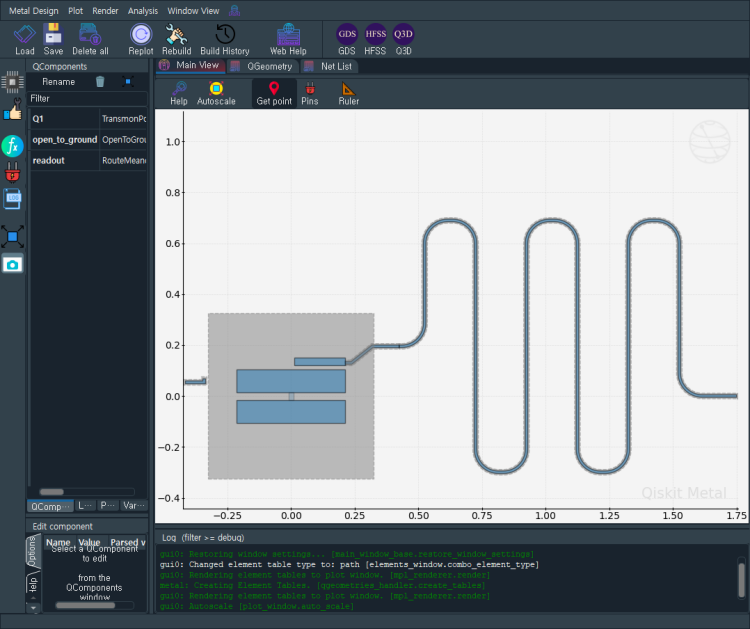

In [8]:
design.delete_all_components()

# you can directly write down the options
# qubit
q1 = TransmonPocketCL(design, 'Q1', 
                      options = dict(pad_width = '425 um', pocket_height = '650um',
                                     connection_pads=dict(readout = dict(loc_W=+1,loc_H=+1, pad_width='200um'))
                                     )
                      )

# open to ground for quarter-wavelength CPW resonator
otg = OpenToGround(design, 'open_to_ground', options=dict(pos_x='1.75mm',  pos_y='0um', orientation='0'))

# CPW resonator
readout = RouteMeander(design, 'readout',  Dict(total_length='6 mm',
                                                hfss_wire_bonds = True,
                                                fillet='90 um',
                                                lead = dict(start_straight='100um'),
                                                pin_inputs=Dict(start_pin=Dict(component='Q1', pin='readout'), end_pin=Dict(component='open_to_ground', pin='open'))
                                                )
                       )

gui.rebuild()
gui.autoscale()

# take a screenshot of the GUI
gui.screenshot()

# Realistic Single-Qubit Device Design with Qubit Control Line and Two-Port Readout Transmission Line

### A device should have signal input/output pads for qubit readout as well as qubit control
### Refer to below papers for further details:

* [two-port readout with individual qubit control line] L DiCarlo *et al.,* "Demonstration of two-qubit algorithms with a superconducting quantum processor," *Nature,* **460**, 240-244 (2009) DOI: https://doi.org/10.1038/nature08121
* [single-port readout with individual qubit control line] Y Sunada *et al.,* "Photon-Noise-Tolerant Dispersive Readout of a Superconducting Qubit Using a Nonlinear Purcell Filter," *PRX Quantum,* **5**, 010307 (2024) DOI: https://doi.org/10.1103/PRXQuantum.5.010307

In case of single-port readout protocol, you should have `microwave circulators` to separate the input readout pulse from the reflected readout pulse

In [9]:
# additional package loads for readout transmission line design
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.terminations.launchpad_wb_driven import LaunchpadWirebondDriven

# built-in transmon qubit design
from qiskit_metal.qlibrary.qubits.transmon_pocket_6 import TransmonPocket6

In [10]:
# transmon qubit's Josephson junction parameters
tr_Ljj = '13 nH' ; tr_Cjj = '2 fF'
# CPW characteristic parameters
cpw_w = '10 um'; cpw_g = '6 um'
# readout resonator parameters
res1_l = '3.5 mm'; res1_coup_l = '600 um'; res1_coup_g = '5 um'

design.delete_all_components()

# options for realistic signal input/output port (NOTE: width of the launchpad should be larger than 300 um in practice)
launch_options = dict(
    chip='main', 
    pos_x="-2.12 mm", 
    pos_y="0mm",  
    orientation='360', 
    lead_length='0um',
    pad_width='300um',
    pad_height='300um',
    pad_gap='180um',
    taper_height='300um'
)
RP1 = LaunchpadWirebondDriven(design, 'RP1', options = launch_options)

# options for realistic signal input/output port (NOTE: width of the launchpad should be larger than 300 um in practice)
launch_options = dict(
    chip='main', 
    pos_x="2.12 mm", 
    pos_y="0mm",  
    orientation='180', 
    lead_length='30um',
    pad_width='300um',
    pad_height='300um',
    pad_gap='180um',
    taper_height='300um'
)
RP2 = LaunchpadWirebondDriven(design, 'RP2', options = launch_options)

# options for built-in capacitive coupling geometry
# you can draw the capacitively coupled geometry using the open/short_to_ground components (see lab01_3)
clt_options = dict(
    chip='main', 
    pos_x="0mm", 
    pos_y="0mm",
    prime_width=cpw_w,
    prime_gap=cpw_g,
    second_width=cpw_w,
    second_gap=cpw_g,
    coupling_space=res1_coup_g,
    coupling_length=res1_coup_l,
    down_length='100um',
    fillet='40um',
    mirror=False,
    open_termination=False,
    hfss_wire_bonds = False
)
CLT1 = CoupledLineTee(design, 'CLT1', options = clt_options)

# draw the readout transmission line (part 1)
route_options = Dict(hfss_wire_bonds = True,
                     pin_inputs=Dict(start_pin=Dict(component='RP1', pin='tie'),
                                     end_pin=Dict(component='CLT1',pin='prime_start')),
                     trace_width=cpw_w, trace_gap=cpw_g)
TL1 = RouteStraight(design, 'TL1', options=route_options)

# draw the readout transmission line (part 2)
route_options = Dict(hfss_wire_bonds = True,
                     pin_inputs=Dict(start_pin=Dict(component='CLT1', pin='prime_end'),
                                     end_pin=Dict(component='RP2',pin='tie')),
                     trace_width=cpw_w, trace_gap=cpw_g)
TL2 = RouteStraight(design, 'TL2', options=route_options)

# draw transmon qubit
tr_options = dict(pos_x="0mm", pos_y="-1.5 mm", orientation = 180,
                  pad_width = '600um', pad_height = '60um', pad_gap = '30um',
                  pocket_height = '300um', pocket_width = '700um', inductor_width = '10um',
                  connection_pads=dict(readout = dict(loc_W=0, loc_H=-1, 
                                                      pad_height='20um', pad_width='200um', pad_gap='20um', pad_shift='0um')),
                  hfss_inductance = tr_Ljj,
                  hfss_capacitance = tr_Cjj
                 )
Q1 = TransmonPocket6(design, 'Q1', options = tr_options)

# draw quarter-wavelength CPW resonator for dispersive qubit readout
route_options = Dict(chip='main',
                     hfss_wire_bonds = True,
                     pin_inputs=Dict(start_pin=Dict(component='Q1',pin='readout'),
                                     end_pin=Dict(component='CLT1',pin='second_end')),
                     trace_width=cpw_w,
                     trace_gap=cpw_g,
                     total_length=res1_l,
                     fillet="80um",
                     meander = dict(spacing = '200um', asymmetry = '0um'),
                     lead = dict(start_straight = '100um', end_straight = '50 um'))
RR1 = RouteMeander(design, 'RR1', options=route_options)

# options for realistic qubit control line port
launch_options = dict(chip='main', pos_x="0mm", pos_y="-2.38mm", orientation='90', 
                      lead_length='0um',
                      pad_width='200um', pad_height='200um', pad_gap='120um', taper_height='200um'
                      )
QCTRLP1 = LaunchpadWirebondDriven(design, 'QCTRLP1', options = launch_options)

OTG = OpenToGround(design, name='OTG1', options=dict(pos_x='0mm',  pos_y='-1.7 mm', orientation='90'))

route_options = Dict(hfss_wire_bonds = True,
                     pin_inputs=Dict(start_pin=Dict(component='OTG1', pin='open'),
                                     end_pin=Dict(component='QCTRLP1',pin='tie')),
                     trace_width=cpw_w, trace_gap=cpw_g)
QCTRLR1 = RouteStraight(design, 'QCTRLR1', options=route_options)

gui.rebuild()
gui.autoscale()

# method (1): Energy Participation Ratio (EPR)

In [11]:
from qiskit_metal.analyses.quantization import EPRanalysis

# project name
proj_name = "lab03_transmon_readout"

eig_s = EPRanalysis(design, "hfss")
hfss = eig_s.sim.renderer

try:
    hfss.start()
except:
    hfss.activate_design(proj_name)

INFO 04:59PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:59PM [load_ansys_project]: 	Opened Ansys App
INFO 04:59PM [load_ansys_project]: 	Opened Ansys Desktop v2023.1.0
INFO 04:59PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/USER/Documents/Ansoft/
	Project:   Project2
INFO 04:59PM [connect_design]: 	Opened active design
	Design:    lab02_grounded_transmon_hfss [Solution type: Eigenmode]
INFO 04:59PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:59PM [connect]: 	Connected to project "Project2" and design "lab02_grounded_transmon_hfss" 😀 



In [12]:
from qiskit_metal.analyses.quantization import EPRanalysis

# define the EPR analysis class
eig_s = EPRanalysis(design, "hfss")

# define the renderer program for the eigenmode simulation
hfss = eig_s.sim.renderer

# try-except to avoid common(?) error during the HFSS rendering
try:
    hfss.start()
except:
    hfss.activate_design(proj_name)

# NOTE: you should define the junction in HFSS
eig_s.setup.junctions.jj.rect = 'JJ_rect_Lj_Q1_rect_jj'
eig_s.setup.junctions.jj.line = 'JJ_Lj_Q1_rect_jj_'

# define the setup
em_s = eig_s.sim.setup
em_s.name = "setup_custom"

# minimum searching frequency
em_s.min_freq_ghz = 3

# target eigenmode number
# NOTE: now you have two components... you should find 'two' eigenmodes
em_s.n_modes = 2

# maximum pass number
em_s.max_passes = 15

# criteria for eigenmode simulation convergence: maximum delta F_eigen between passes < value
em_s.max_delta_f = 0.5

# simulation minimum converged passes 
em_s.min_converged = 2

# simulation order 0: point, 1: line, 2: face
em_s.basis_order = 1

# Design variables can also be added in for direct simulation sweeps. Here, we have to set the junction inductance and capacitance
em_s.vars = Dict({'Lj': tr_Ljj, 'Cj': tr_Cjj})


INFO 04:59PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:59PM [load_ansys_project]: 	Opened Ansys App
INFO 04:59PM [load_ansys_project]: 	Opened Ansys Desktop v2023.1.0
INFO 04:59PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/USER/Documents/Ansoft/
	Project:   Project2
INFO 04:59PM [connect_design]: 	Opened active design
	Design:    lab02_grounded_transmon_hfss [Solution type: Eigenmode]
INFO 04:59PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:59PM [connect]: 	Connected to project "Project2" and design "lab02_grounded_transmon_hfss" 😀 



In [13]:
eig_s.sim._render(name=proj_name,                         # design name
                  selection = [],                         # if None --> all
                  solution_type='eigenmode',              # NOTE: case sensitive
                  vars_to_initialize=em_s.vars,           # set variables
                  open_pins=[],                           # set open pins
                  port_list=[],                           # set ports, for eigenmode simulations --> R = 50 Ohm boundary conditions 
                  box_plus_buffer = False)                # if False --> set the overall layout as you defined above. If True --> set marginal chip sizes as you set here.

INFO 04:59PM [connect_design]: 	Opened active design
	Design:    lab03_transmon_readout_hfss [Solution type: Eigenmode]


'lab03_transmon_readout_hfss'

In [14]:
# mesh setting name, components, maximum mesh length
hfss.modeler.mesh_length('qubitpad_mesh_setting', 
                         ['pad_bot_Q1', 'pad_top_Q1', 'readout_connector_pad_Q1'], 
                         MaxLength='0.1 mm')

hfss.modeler.mesh_length('cpw_mesh_setting', 
                         ['trace_RR1', 'prime_cpw_CLT1', 'second_cpw_CLT1'], 
                         MaxLength='0.05 mm')

In [15]:
eig_s.sim._analyze()

INFO 04:59PM [get_setup]: 	Opened setup `setup_custom`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:59PM [analyze]: Analyzing setup setup_custom
05:01PM 37s INFO [get_f_convergence]: Saved convergences to c:\Users\USER\Documents\GitHub\sqc_lecture_notes\tutorials\hfss_eig_f_convergence.csv


In [16]:
pinfo = hfss.pinfo
pinfo.junctions['jj'] = {'Lj_variable': 'Lj', 'rect': 'JJ_rect_Lj_Q1_rect_jj', 'line': 'JJ_Lj_Q1_rect_jj_',  'Cj_variable': 'Cj'}
pinfo.validate_junction_info() # Check that valid names of variables and objects have been supplied

In [17]:
eprd = epr.DistributedAnalysis(pinfo)
eprd.do_EPR_analysis()

Design "lab03_transmon_readout_hfss" info:
	# eigenmodes    2
	# variations    1

Variation 0  [1/1]

  Mode 0 at 4.94 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%  2.053e-24 2.088e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.55%
	jj               1.01465  (+)        0.0254496
		(U_tot_cap-U_tot_ind)/mean=0.03%

  Mode 1 at 6.33 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.5%  1.145e-24 1.139e-24

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.06%
	jj              0.00523103  (+)        0.000214839
		(U_tot_cap-U_tot_ind)/mean=0.00%

ANALYSIS DONE. Data saved to

(WindowsPath('C:/data-pyEPR/Project2/lab03_transmon_readout_hfss/2025-02-03 17-01-37.npz'),
 ['0'])

In [18]:
epra = epr.QuantumAnalysis(eprd.data_filename)
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 10)

WARNING 05:01PM [__init__]: <p>Error: <class 'IndexError'></p>


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Using taylor expansion
Starting the diagonalization
Finished the diagonalization
(2, 1)
Single junctions -- assuming single qubit mode
The biggest elements in the fidelity list are:
Element: 0.9999915201749243, Index: 0
Element: 0.9997981269825532, Index: 1
Element: 0.9988287723959349, Index: 3
Element: 0.9967429570420974, Index: 6
Element: 0.9934433677789232, Index: 8
Element: 0.9890888595753162, Index: 12
Element: 0.9834304162370437, Index: 16
Element: 0.9688204670960864, Index: 21
Element: 0.7283882201768292, Index: 29
Element: 0.9836092936087893, Index: 42
4689838447.409752 4689838447.409752
9106395203.01609
4689838447.409752 6324083226.027043
11011677418.519459
6324083226.027043 6324083226.027043
12648160680.698803
Pm_norm=
modes
0    1.000614
1    1.000413
dtype: float64

Pm_norm idx =
      jj
0   True
1  False
*** P (participation matrix, not normlz.)
 

OrderedDict([('0',
              OrderedDict([('f_0', 0    4943.277534
                            1    6325.529290
                            Name: 0, dtype: float64),
                           ('f_1',
                            0    4703.541296
                            1    6323.908826
                            dtype: float64),
                           ('f_ND',
                            0     4689.838447
                            1     6324.083226
                            2        0.000000
                            3     4689.838447
                            4     9106.395203
                            5    13220.532065
                            6    17026.842945
                            dtype: float64),
                           ('chi_O1',
                                        0         1
                            0  238.126653  3.219169
                            1    3.219169  0.010880),
                           ('chi_ND',
                       

# Method (2): Capacitance Analysis and LOM derivation using the analysis package

In [19]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [20]:
# example: update single setting
c1.sim.setup.max_passes = 20
c1.sim.setup.freq_ghz = 5

# example: update multiple settings
c1.sim.setup_update(solution_order = 'Medium', auto_increase_solution_order = 'False')

c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5,
 'save_fields': False,
 'enabled': True,
 'max_passes': 20,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': 'False',
 'solution_order': 'Medium',
 'solver_type': 'Iterative'}

In [21]:
# you should define the open terminations, where coupling structures of a qubit end
c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'readout')])

# c1.setup.run <- direct access
c1.sim.print_run_args()

INFO 05:01PM [connect_project]: Connecting to Ansys Desktop API...
INFO 05:01PM [load_ansys_project]: 	Opened Ansys App
INFO 05:01PM [load_ansys_project]: 	Opened Ansys Desktop v2023.1.0
INFO 05:01PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/USER/Documents/Ansoft/
	Project:   Project2
INFO 05:01PM [connect_design]: 	Opened active design
	Design:    lab03_transmon_readout_hfss [Solution type: Eigenmode]
INFO 05:01PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 05:01PM [connect]: 	Connected to project "Project2" and design "lab03_transmon_readout_hfss" 😀 

INFO 05:01PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 05:01PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:01PM [analyze]: Analyzing setup Setup
INFO 05:02PM [get_matrix]: Exporting matrix data to (C:\Users\USER\AppData\Local\Temp\tmpdwlpfne0.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "

This analysis object run with the following kwargs:
{'name': None, 'components': ['Q1'], 'open_terminations': [('Q1', 'readout')], 'box_plus_buffer': True}



In [22]:
c1.sim.capacitance_matrix

,ground_main_plane,pad_bot_Q1,pad_top_Q1,readout_connector_pad_Q1
ground_main_plane,236.36640,-56.35580,-62.03162,-64.26589
pad_bot_Q1,-56.35580,111.03397,-38.49551,-14.48235
pad_top_Q1,-62.03162,-38.49551,104.33625,-1.78282
readout_connector_pad_Q1,-64.26589,-14.48235,-1.78282,80.88428


In [23]:
# NOTE: you should define the same values for Josephson junction parameters!
c1.setup.junctions = Dict({'Lj': 13, 'Cj': 2}) # Lj unit: nH and Cj unit: fF

# NOTE: you have to define the readout resonator's frequency!
c1.setup.freq_readout = 6.33 # unit: GHz
c1.setup.freq_bus = []      # if there is additional coupling bus resonators, you should define their frequencies

c1.run_lom()
c1.lumped_oscillator_all

INFO 05:02PM [__del__]: Disconnected from Ansys HFSS
INFO 05:02PM [__del__]: Disconnected from Ansys HFSS


[1, 2] [3]
Predicted Values

Transmon Properties
f_Q 4.851966 [GHz]
EC 261.522824 [MHz]
EJ 12.568892 [GHz]
alpha -301.431945 [MHz]
dispersion 14.432362 [KHz]
Lq 12.994758 [nH]
Cq 74.067065 [fF]
T1 142.991914 [us]

**Coupling Properties**

tCqbus1 5.925555 [fF]
gbus1_in_MHz 71.417915 [MHz]
χ_bus1 -1.194395 [MHz]
1/T1bus1 1113.034567 [Hz]
T1bus1 142.991914 [us]
Bus-Bus Couplings


,fQ,EC,EJ,alpha,dispersion,gbus,T1bus_in_us,chi_in_MHz,χr MHz,gr MHz
1,5.131645,294.759924,12.568892,-343.638852,43.215442,[68.31698201821149],[9.648294544349991e-05],[-1.761059612740804],1.761060,68.316982
2,5.120901,293.440844,12.568892,-341.947413,41.525908,[70.57480541857672],[9.225020494436207e-05],[-1.843138316995466],1.843138,70.574805
3,5.085349,289.100344,12.568892,-336.391272,36.347758,[68.52895275082011],[0.00010448171921843691],[-1.6305619248638488],1.630562,68.528953
4,5.013685,280.463702,12.568892,-325.379502,27.627665,[69.56632111555568],[0.00011520525320738604],[-1.4825543741858729],1.482554,69.566321
5,4.955959,273.615824,12.568892,-316.689576,22.02068,[69.54068821942168],[0.00012726212205321603],[-1.343204025764296],1.343204,69.540688
6,4.919229,269.30887,12.568892,-311.24263,19.007355,[69.91729066634599],[0.0001338295588083123],[-1.2773091405299755],1.277309,69.917291
7,4.897112,266.734379,12.568892,-307.993529,17.376818,[70.22822155155218],[0.00013753506093075005],[-1.2426877367899936],1.242688,70.228222
8,4.873749,264.030048,12.568892,-304.586052,15.791813,[70.86794084895428],[0.00014025865885497414],[-1.2181746720946198],1.218175,70.867941
9,4.861777,262.650331,12.568892,-302.84976,15.031031,[71.01704425938158],[0.0001423716306836831],[-1.1998395536943915],1.199840,71.017044
10,4.851966,261.522824,12.568892,-301.431945,14.432362,[71.41791514693574],[0.00014299191405488725],[-1.1943952285472923],1.194395,71.417915


# Method (3): New LOM analysis

In [24]:
import scqubits as scq

from scipy.constants import speed_of_light as c_light
from qiskit_metal.analyses.quantization.lumped_capacitive import load_q3d_capacitance_matrix
from qiskit_metal.analyses.quantization.lom_core_analysis import CompositeSystem, Cell, Subsystem, QuantumSystemRegistry

05:02PM 13s INFO [__init__]: TransmonBuilder with system_type TRANSMON registered to QuantumSystemRegistry
05:02PM 13s INFO [__init__]: FluxoniumBuilder with system_type FLUXONIUM registered to QuantumSystemRegistry
05:02PM 13s INFO [__init__]: TLResonatorBuilder with system_type TL_RESONATOR registered to QuantumSystemRegistry
05:02PM 13s INFO [__init__]: LumpedResonatorBuilder with system_type LUMPED_RESONATOR registered to QuantumSystemRegistry


In [25]:
QuantumSystemRegistry.registry()

{'TRANSMON': qiskit_metal.analyses.quantization.lom_core_analysis.TransmonBuilder,
 'FLUXONIUM': qiskit_metal.analyses.quantization.lom_core_analysis.FluxoniumBuilder,
 'TL_RESONATOR': qiskit_metal.analyses.quantization.lom_core_analysis.TLResonatorBuilder,
 'LUMPED_RESONATOR': qiskit_metal.analyses.quantization.lom_core_analysis.LumpedResonatorBuilder}

### 1. load transmon cell Q3d simulation results and set cell objects corresponding to the capacitance simulation results 
Loading the Maxwell capacitance matrices for the design from ANSYS Q3D

For a simple introduction on Maxwell capacitance matrix, check out the following resources:
https://www.fastfieldsolvers.com/Papers/The_Maxwell_Capacitance_Matrix_WP110301_R02.pdf

The following three parameters, `ind_dict`, `jj_dict`, `cj_dict`, all have the same structure. Each is a dictionary where the keys are tuples, giving the nodes that a junction is in between, and the values specifying the relevant values associated with the junction. `ind_dict` lets you specify the junction inductance in nH; `jj_dict` specifies the Josephson junction name (you can give the junction any name you wish; just need to be consistent with the name); `cj_dict` specifies the junction capacitance in fF.

In [26]:
# cell 1: transmon qubit Q1

opt1 = dict(node_rename = {'readout_connector_pad_Q1': 'coupler_RR1'}, 
            cap_mat = c1.sim.capacitance_matrix,
            ind_dict = {('pad_top_Q1', 'pad_bot_Q1'):13},  # junction inductance in nH
            jj_dict = {('pad_top_Q1', 'pad_bot_Q1'):'j1'},
            cj_dict = {('pad_top_Q1', 'pad_bot_Q1'):2},    # junction capacitance in fF
            )

cell_1 = Cell(opt1)

### 2. Create subsystems
#### Creating the four subsystems, corresponding to the qubit-readout resonator

`Subsystem` takes three required arguments. The four currently supported system types are `TRANSMON`, `FLUXONIUM`, `TL_RESONATOR` (transmission line resonator) and `LUMPED_RESONATOR`. `nodes` lets you specify which node the subsystem should be mapped to in the cells. They should be consistent with the node names you have given previously. `q_opts` lets specify any optional parameters you want to give. For example, for qubits, you can provide `scqubits` parameters such as `ncut`, `truncated_dim` here.

In [27]:
# subsystem 1: transmon qubit Q1
transmon_Q1 = Subsystem(name='Q1', sys_type='TRANSMON', nodes=['j1'])

# subsystem 2: readout resonator RR1
q_opts = dict(f_res = 6.33,           # resonator dressed frequency in GHz
              Z0 = 50,                # characteristic impedance in Ohm
              vp = 0.404314 * c_light # phase velocity 
)
res_RR1 = Subsystem(name='RR1', sys_type='TL_RESONATOR', nodes=['coupler_RR1'], q_opts=q_opts)

### 3. Create the composite system from the cells and the subsystems

The LOM analysis will automatically remove all non-dynamic nodes. These are nodes that are either exclusively connected to only capacitors or only inductors and are not true degrees of freedom. 

please check out https://arxiv.org/pdf/2103.10344.pdf or https://cpb-us-w2.wpmucdn.com/campuspress.yale.edu/dist/2/3627/files/2020/10/Vool_Intro_quantum_electromagnetic_circuits.pdf for more information on this

Since we didn't (and didn't have to) simulate the readout resonator, the node, `coupler_RR1`, connected only to other nodes capacitively as specified by the Maxwell capacitance matrices, would be eliminated. But they are actually dynamic nodes, connected to the inductors (not simulated) of the respective transmission lines and correspond to subsystems that we want to include in the Hamiltonian of the composite system, hence we list them as nodes to force keep with the parameter `nodes_force_keep`.

In [28]:
composite_sys = CompositeSystem(subsystems=[transmon_Q1, res_RR1], 
                                cells=[cell_1], 
                                grd_node='ground_main_plane',
                                nodes_force_keep=['coupler_RR1']
                                )

The `circuitGraph` object encapsulates the lumped model circuit analysis (i.e., LOM analysis) and contain the intermediate as well as final L and C matrices, their inverses needed to construct the Hamiltonian of the composite system. For more details on the meaning and calculation of these matrices, check out https://arxiv.org/pdf/2103.10344.pdf.

Just to note that you can use the analysis without needing to know any detail about this object.

In [29]:
cg = composite_sys.circuitGraph()
print(cg)

node_jj_basis:
-------------

['j1', 'pad_bot_Q1', 'coupler_RR1']

nodes_keep:
-------------

['j1', 'coupler_RR1']


L_inv_k (reduced inverse inductance matrix):
-------------

                   j1  coupler_RR1
j1           0.076923          0.0
coupler_RR1  0.000000          0.0

C_k (reduced capacitance matrix):
-------------

                    j1  coupler_RR1
j1           75.009266     5.956138
coupler_RR1   5.956138    78.972463




### 4. Generate the hilberspace from the composite system, leveraging the scqubits package

In [30]:
hilbertspace = composite_sys.create_hilbertspace()
print(hilbertspace)

HilbertSpace:  subsystems
-------------------------

Transmon------------| [Transmon_1]
                    | EJ: 12573.962523598551
                    | EC: 259.7936705370599
                    | ng: 0.001
                    | ncut: 22
                    | truncated_dim: 10
                    |
                    | dim: 45


Oscillator----------| [Oscillator_1]
                    | E_osc: 6330.0
                    | l_osc: None
                    | truncated_dim: 3
                    |
                    | dim: 3




`add_interaction()` adds the interaction terms between the subsystems. Currently, capacitive coupling is supported (which is extracted by from off-diagonal elements in the C matrices, see *eqn 12, 13* in https://arxiv.org/pdf/2103.10344.pdf ) and contribute to the interaction.

In [31]:
hilbertspace = composite_sys.add_interaction()
hilbertspace.hamiltonian()

Quantum object: dims = [[10, 3], [10, 3]], shape = (30, 30), type = oper, isherm = True
Qobj data =
[[-10084.6771774 +0.00000000e+00j      0.        +6.18453758e-02j
       0.        +0.00000000e+00j      0.        +0.00000000e+00j
       0.        -6.66974911e+01j      0.        +0.00000000e+00j
       0.        +0.00000000e+00j      0.        +5.27836812e-06j
       0.        +0.00000000e+00j      0.        +0.00000000e+00j
       0.        +2.46980977e+00j      0.        +0.00000000e+00j
       0.        +0.00000000e+00j      0.        -7.25280746e-05j
       0.        +0.00000000e+00j      0.        +0.00000000e+00j
       0.        -2.07523144e-01j      0.        +0.00000000e+00j
       0.        +0.00000000e+00j      0.        +2.94330660e-04j
       0.        +0.00000000e+00j      0.        +0.00000000e+00j
       0.        -2.63970795e-02j      0.        +0.00000000e+00j
       0.        +0.00000000e+00j      0.        +2.00066890e-03j
       0.        +0.00000000e+00j      0. 

### 5. Print the results

Print the calculated Hamiltonian parameters from diagonalized composite system Hamiltonian.

The diagonal elements of the $\chi$ matrix are the anharmonicities of the respective subsystems and the off-diagonal the dispersive shifts between them. 

In [32]:
hamiltonian_results = composite_sys.hamiltonian_results(hilbertspace, evals_count=30)


system frequencies in GHz:
--------------------------
{'Q1': 4.833536314800205, 'RR1': 6.332574519438989}

Chi matrices in MHz
--------------------------
             Q1       RR1
Q1  -298.135376 -1.267897
RR1   -1.267897  1.187455


The $\chi$'s between the subsystems are based on the coupling strengths, $\it{g}$'s between them (which are computed using the coupling capacitance (currently capacitive coupling is supported) and zero point fluctuations of the subsystem's charge operator at the coupling location).

In [33]:
composite_sys.compute_gs()

                    j1  coupler_RR1
j1            0.000000   -61.845491
coupler_RR1 -61.845491     0.000000

# LAB HOMEWORK

### Transmon qubit-resonator system simulations. You should achieve the target parameters within 5\%. The overall circuit layout, electric field distributions, simulations settings in ANSYS (including $L_J, C_J$ values), and the convergence plot vs. adaptive pass should be attached to the report.

1. Design a double pad qubit and a readout resonator to have $\omega_q/2\pi=4.5$ GHz, $\omega_r/2\pi=6.5$ GHz, $\chi/2\pi=5$ MHz from the `EPR` method. You have to modify the geometric features of a transmon qubit and a readout resonator.
1. Design a Xmon qubit (`from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross`) and a readout resonator to have $\omega_q/2\pi=4.5$ GHz, $\omega_r/2\pi=6.5$ GHz, $\chi/2\pi=5$ MHz from the `EPR` method. You have to modify the geometric features of a transmon qubit and a readout resonator (also Josephson junction parameters, if necessary).
2. Modify the substrate material into `sapphire` with a dielectric constant of `10`. Then, design a double pad qubit and a readout resonator to have $\omega_q/2\pi=4.5$ GHz, $\omega_r/2\pi=6.0$ GHz, $\chi/2\pi=2$ MHz from the `EPR` method. You have to modify the geometric features of a transmon qubit and a readout resonator.
3. Design a double pad qubit and a readout resonator to have $\omega_q/2\pi=5.0$ GHz, while varying the readout resonator frequency $\omega_r$ to obtain $\chi/2\pi=5$ MHz from the `LOM` and `NEW LOM` methods. You have to modify the geometric features of transmon qubit and Josephson junction parameters.